### Package

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact

### DL Data

#### From .h5ad file

In [2]:
'''
data_1 = sc.read_h5ad('../Data/FILE_NAME.h5ad')
data_1.var_names_make_unique()
data_2 = sc.read_h5ad('../Data/FILE_NAME.h5ad')
data_2.var_names_make_unique()
'''

"\ndata_1 = sc.read_h5ad('../Data/FILE_NAME.h5ad')\ndata_1.var_names_make_unique()\ndata_2 = sc.read_h5ad('../Data/FILE_NAME.h5ad')\ndata_2.var_names_make_unique()\n"

#### From .mtx and .tsv

In [3]:
'''
data_1 = sc.read_mtx('matrix.mtx').T
genes_1 = pd.read_csv('genes.tsv', sep='\t', header=None, names=['gene_ids', 'genes'])
barcodes_1 = pd.read_csv('barcodes.tsv', sep='\t', header=None, names=['barcodes'])
data_1.var = genes
data_1.obs = barcodes
data_1.var_names_make_unique()

data_2 = sc.read_mtx('matrix.mtx').T
genes_2 = pd.read_csv('genes.tsv', sep='\t', header=None, names=['gene_ids', 'genes'])
barcodes_2 = pd.read_csv('barcodes.tsv', sep='\t', header=None, names=['barcodes'])
data_2.var = genes
data_2.obs = barcodes
data_2.var_names_make_unique()
'''

"\ndata_1 = sc.read_mtx('matrix.mtx').T\ngenes_1 = pd.read_csv('genes.tsv', sep='\t', header=None, names=['gene_ids', 'genes'])\nbarcodes_1 = pd.read_csv('barcodes.tsv', sep='\t', header=None, names=['barcodes'])\ndata_1.var = genes\ndata_1.obs = barcodes\ndata_1.var_names_make_unique()\n\ndata_2 = sc.read_mtx('matrix.mtx').T\ngenes_2 = pd.read_csv('genes.tsv', sep='\t', header=None, names=['gene_ids', 'genes'])\nbarcodes_2 = pd.read_csv('barcodes.tsv', sep='\t', header=None, names=['barcodes'])\ndata_2.var = genes\ndata_2.obs = barcodes\ndata_2.var_names_make_unique()\n"

#### From .h5 file

In [4]:
data_1 = sc.read_10x_h5('../Data/Sample/PBS_filtered_feature_bc_matrix.h5', )
data_1.var_names_make_unique()
data_2 = sc.read_10x_h5('../Data/Sample/SWITCH2_filtered_feature_bc_matrix.h5')
data_2.var_names_make_unique()
data_1, data_2

C:\ProgramData\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(AnnData object with n_obs × n_vars = 5813 × 32285
     var: 'gene_ids', 'feature_types', 'genome',
 AnnData object with n_obs × n_vars = 9128 × 32285
     var: 'gene_ids', 'feature_types', 'genome')

### Data management

#### Data merging

In [5]:
# Bidouillage réglé par les data_1.var_names_make_unique() plus hauts
#data = data_1.T.concatenate(data_2.T, join='outer')
#data = data.T

In [6]:
data_1.obs['type']="mouse"
data_1.obs['sample']="PBS"
data_2.obs['type']="mouse"
data_2.obs['sample']="SWITCH2"

In [7]:
adata = data_1.concatenate(data_2)
adata

C:\ProgramData\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 14941 × 32285
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

#### Isoler les gènes mitochondriaux 
Peut être fait sur d'autre type de gènes (ribosomique, hemoglobine).

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') 
#adata.var['mt']

In [9]:
mito_genes = [gene for gene in adata.var_names if gene.startswith('mt-') or gene.startswith('MT-') or gene.startswith('Mt-')]
mito_genes

['mt-Nd1',
 'mt-Nd2',
 'mt-Co1',
 'mt-Co2',
 'mt-Atp8',
 'mt-Atp6',
 'mt-Co3',
 'mt-Nd3',
 'mt-Nd4l',
 'mt-Nd4',
 'mt-Nd5',
 'mt-Nd6',
 'mt-Cytb']

In [10]:
# Créer une matrice de comptage uniquement pour les gènes mitochondriaux
counts_matrix = adata[:, mito_genes].X.toarray()
counts_matrix.shape

(14941, 13)

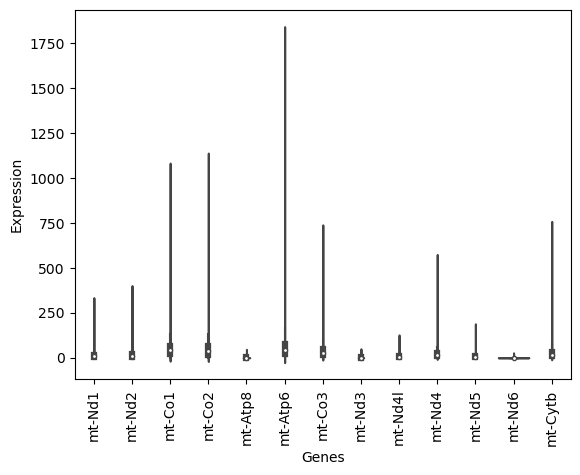

In [11]:
sns.violinplot(data=counts_matrix,)
plt.xticks(rotation=90)
plt.xticks(range(len(mito_genes)), mito_genes)
plt.xlabel("Genes")
plt.ylabel("Expression")
plt.savefig('./Figures/count_mito_genes.pdf')
plt.show()

In [12]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [13]:
adata.obs['percent_mt2'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

#### visualisation

In [14]:
#adata.obs

In [15]:
adata.obs['sample'].value_counts()

SWITCH2    9128
PBS        5813
Name: sample, dtype: int64

In [55]:
adata_raw = adata

def plot_graph(b):
    if b != 'All': 
        sc.pl.violin(adata_raw, [b], jitter=0.4, groupby = 'sample', rotation= 45, save ='')
        
    else :
        sc.pl.violin(adata_raw, ['n_genes_by_counts', 'total_counts'],
        #sc.pl.violin(adata_raw, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], #avec les données des mito
        jitter=0.4, groupby = 'sample', rotation= 45, save ='')

interact(
    plot_graph,
    b = ['n_genes_by_counts', 'total_counts', 'All'],
    #b = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'All'], #avec les données des mito
)

interactive(children=(Dropdown(description='b', options=('n_genes_by_counts', 'total_counts', 'All'), value='n…

<function __main__.plot_graph(b)>

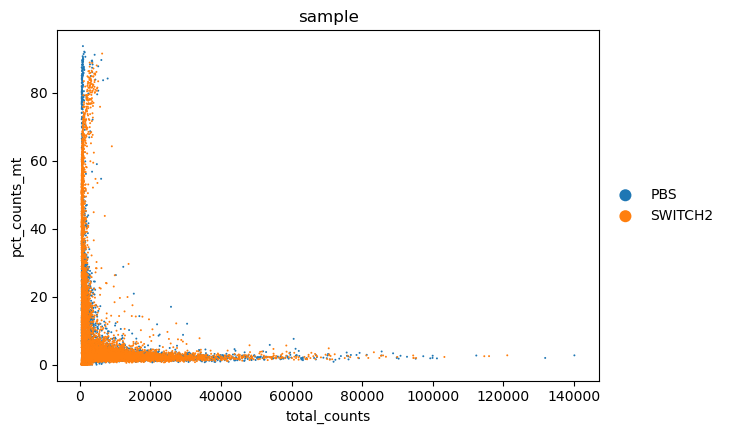

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="sample", save ='') # avec les données des mito

#### Cleaning 

In [18]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, max_genes=6000)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

14404 17285


In [19]:
adata.obs

type   sample batch  n_genes_by_counts  total_counts  \
AAACCCACACCCTGTT-1-0  mouse      PBS     0               2785       10201.0   
AAACCCACACTCCGGA-1-0  mouse      PBS     0               5444       38114.0   
AAACCCAGTAAGACCG-1-0  mouse      PBS     0               1941        6018.0   
AAACCCATCGCTGATA-1-0  mouse      PBS     0               5369       36217.0   
AAACGAAAGCATCTTG-1-0  mouse      PBS     0               3050       11895.0   
...                     ...      ...   ...                ...           ...   
TTTGTTGGTGTCATCA-1-1  mouse  SWITCH2     1               2195        7086.0   
TTTGTTGGTTAGCGGA-1-1  mouse  SWITCH2     1               1127        2423.0   
TTTGTTGTCCCGGTAG-1-1  mouse  SWITCH2     1                398         600.0   
TTTGTTGTCTCTGGTC-1-1  mouse  SWITCH2     1               2279        6274.0   
TTTGTTGTCTTCGTAT-1-1  mouse  SWITCH2     1               1201        2426.0   

                      total_counts_mt  pct_counts_mt  percent_mt2  n_counts  \
AAACCCACACCCTGTT-1-0            254.0       2.489952     0.024900   10201.0   
AAACCCACACTCCGGA-1-0            915.0       2.400693     0.024007   38114.0   
AAACCCAGTAAGACCG-1-0             95.0       1.578598     0.015786    6018.0   
AAACCCATCGCTGATA-1-0           1016.0       2.805312     0.028053   36217.0   
AAACGAAAGCATCTTG-1-0            202.0       1.698193     0.016982   11895.0   
...                               ...            ...          ...       ...   
TTTGTTGGTGTCATCA-1-1            220.0       3.104713     0.031047    7086.0   
TTTGTTGGTTAGCGGA-1-1             64.0       2.641354     0.026414    2423.0   
TTTGTTGTCCCGGTAG-1-1             12.0       2.000000     0.020000     600.0   
TTTGTTGTCTCTGGTC-1-1            134.0       2.135798     0.021358    6274.0   
TTTGTTGTCTTCGTAT-1-1            144.0       5.935697     0.059357    2426.0   

                      n_genes  
AAACCCACACCCTGTT-1-0     2785  
AAACCCACACTCCGGA-1-0     5444  
AAACCCAGTAAGACCG-1-0     1941  
AAACCCATCGCTGATA-1-0     5369  
AAACGAAAGCATCTTG-1-0     3050  
...                       ...  
TTTGTTGGTGTCATCA-1-1     2195  
TTTGTTGGTTAGCGGA-1-1     1127  
TTTGTTGTCCCGGTAG-1-1      398  
TTTGTTGTCTCTGGTC-1-1     2279  
TTTGTTGTCTTCGTAT-1-1     1201  

[14404 rows x 10 columns]

In [20]:
# retirer les barcode en doublon 
adata.obs = adata.obs.drop_duplicates()

In [21]:
# filter for percent mito
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 12672


C:\ProgramData\Anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


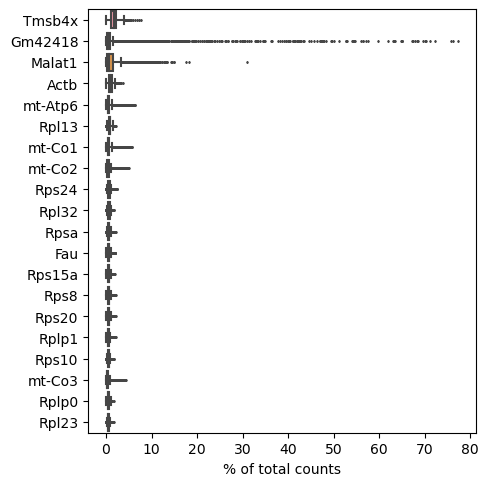

In [22]:
sc.pl.highest_expr_genes(adata, n_top=20, save ='')

#### visualisation clean

In [23]:
def plot_graph(b):
    if b != 'All': 
        sc.pl.violin(adata, [b],
        jitter=0.4, groupby = 'sample', rotation= 45, save ='_clean')
    else :
        sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        jitter=0.4, groupby = 'sample', rotation= 45 ,save ='_clean')

interact(
    plot_graph,
    b = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'All'],
)

interactive(children=(Dropdown(description='b', options=('n_genes_by_counts', 'total_counts', 'pct_counts_mt',…

<function __main__.plot_graph(b)>

- faire la normalisation

In [24]:
sc.pp.normalize_per_cell(adata) #normalisation avec les paramètres par défault

selecion de genen var 

- faire le scale 

In [25]:
sc.pp.scale(adata)

### PCA

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


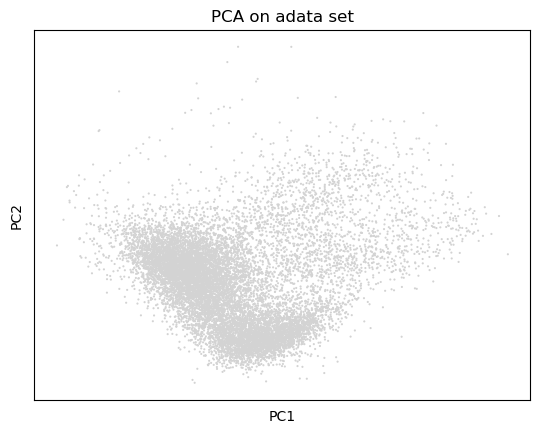

In [26]:
sc.tl.pca(adata)
sc.pl.pca(adata, colorbar_loc='right', title='PCA on adata set', save ='')

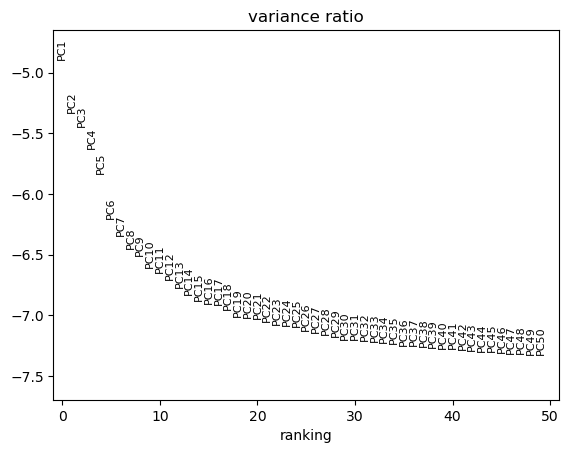

In [27]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, save='') # scanpy generates the filename automatically

In [28]:
#sc.pp.normalize_per_cell(adata) #normalisation avec les paramètres par défault

### UMAP

In [29]:
sc.pp.neighbors.getdoc

functools.partial(<function getdoc at 0x000001B373218160>, <function neighbors at 0x000001B3743CD430>)

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


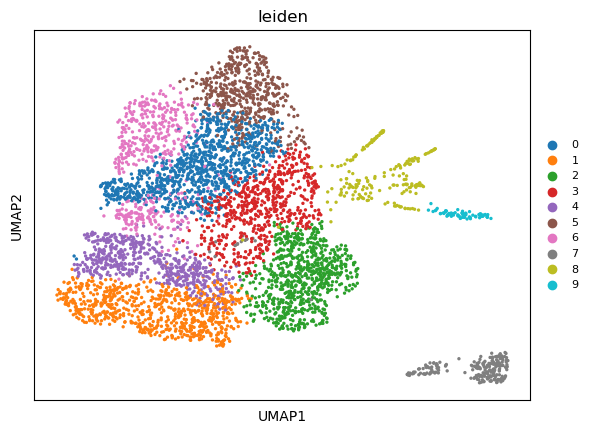

In [30]:
sc.pp.neighbors(adata, n_neighbors= 15, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'], legend_fontsize=8, save='_leiden')
sc.tl.leiden(adata, resolution=0.5, key_added="clusters")

In [31]:
def plot_graph(n_neighbor, pca):
    sc.pp.neighbors(adata, n_neighbors= n_neighbor, n_pcs=pca)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.5, key_added="clusters")
    sc.pl.umap(adata, color=['leiden'], legend_fontsize=8)

interact(
    plot_graph,
    n_neighbor = (10,50,1),
    pca = (15,40,1)
)

interactive(children=(IntSlider(value=30, description='n_neighbor', max=50, min=10), IntSlider(value=27, descr…

<function __main__.plot_graph(n_neighbor, pca)>

- UMAP  visualisation : 

métriques de qualité de l'UMAP (mitochondrie, nombre d'UMI, nombre de gènes)


In [32]:
adata.obs['UMAP n_genes_by_counts'] = (adata.X > 0).sum(1)
adata.obs['UMAP total_counts'] = adata.X.sum(1)
adata.obs['UMAP pct_counts_mt'] = adata.obs['n_genes_by_counts'] / adata.shape[1] * 100

def plot_graph(b):
    if b != 'All': 
        sc.pl.umap(adata, color=b, show=False, save ='')

    else :
        sc.pl.umap(adata, color=['UMAP n_genes_by_counts', 'UMAP total_counts', 'UMAP pct_counts_mt'], show=False, save ='')

interact(
    plot_graph,
    b = ['UMAP n_genes_by_counts', 'UMAP total_counts', 'UMAP pct_counts_mt', 'All'],
)

interactive(children=(Dropdown(description='b', options=('UMAP n_genes_by_counts', 'UMAP total_counts', 'UMAP …

<function __main__.plot_graph(b)>

- Regarder l'expression de certains gènes caractéristiques de certains type cellulaire sur des UMAP ou un dotplot :

In [33]:
# check the presence of genes 
#liste_maj = ["CD8A", "SELL","IFNG", "GZMK", "GZMA", "GZMB", "CCR7", "IL7R", "MKI67","CISH"]
liste_min = ['Sell', 'Ccr7', 'Lef1', 'Mki67', 'Gzma', 'Gzmb', 'Ccl5', 'Fcer1g', 'Tyrobp','Mlana']
liste_maj = [texte.upper() for texte in liste_min]

for i in range(len(liste_maj)) :
    see = [gene for gene in adata.var_names if gene.startswith(liste_maj[i]) or gene.startswith(liste_min[i])]
    print(see)

['Sell']
['Ccr7']
['Lef1os1', 'Lef1']
['Mki67']
['Gzma']
['Gzmb']
['Ccl5']
['Fcer1g']
['Tyrobp']
['Mlana']


In [34]:
marker_genes = liste_min

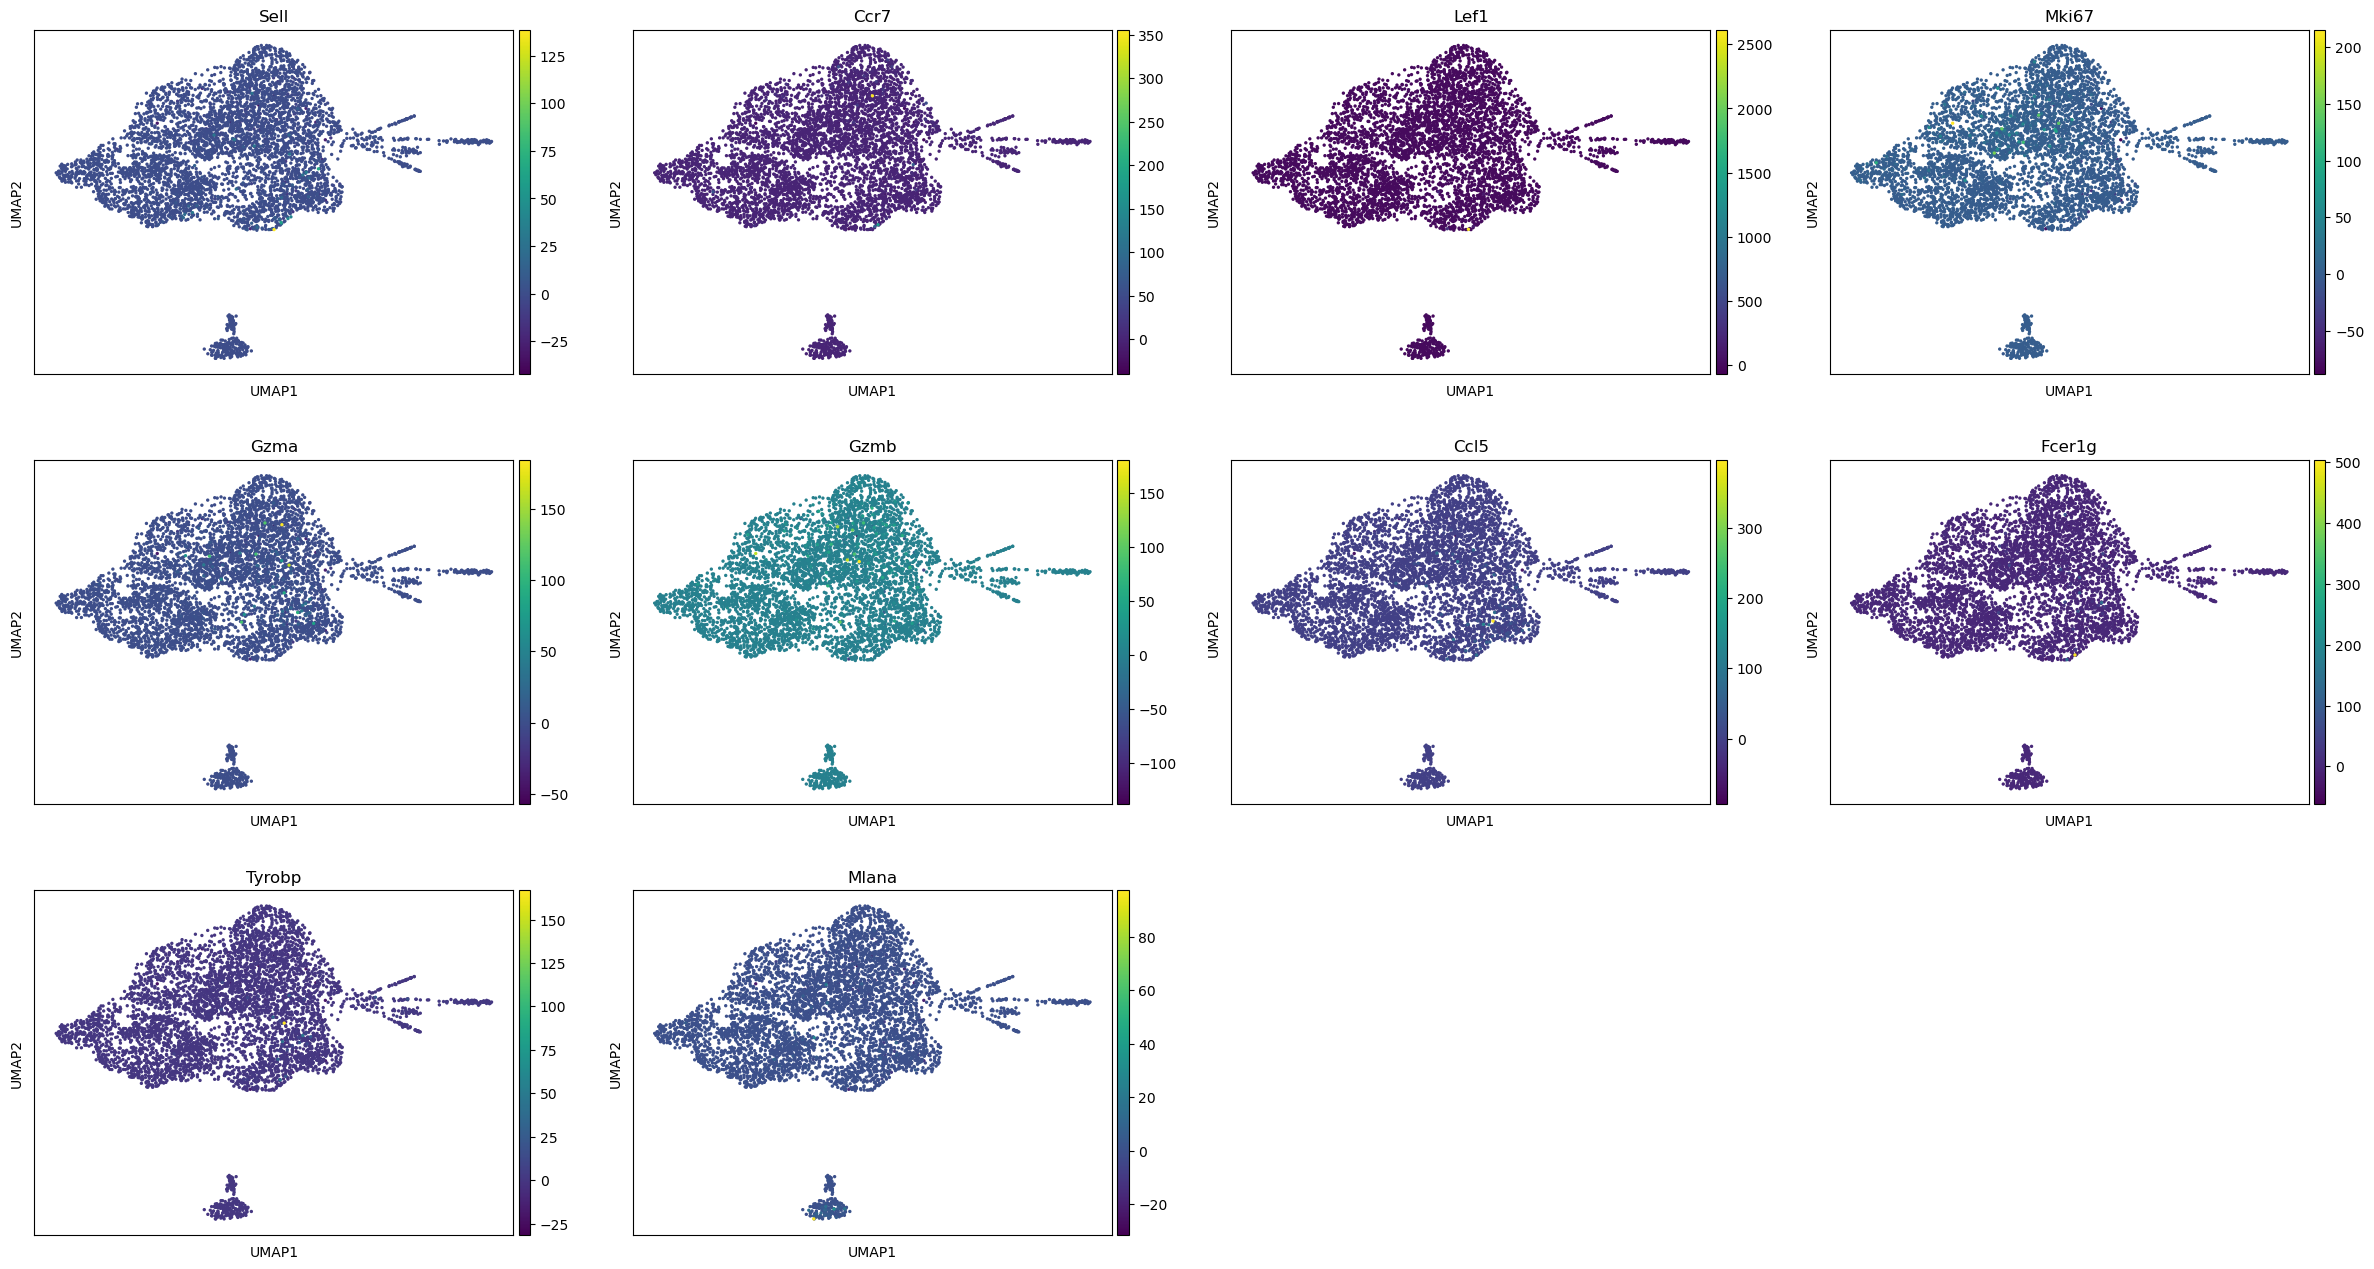

In [35]:
sc.pl.umap(adata, color = marker_genes, save = '')

In [36]:
'''
marker_genes_dict = {
    'Lymphocyte_T': ["CD8A", "SELL","IFNG", "GZMK", "GZMA", "GZMB", "CCR7", "IL7R", "MKI67","CISH"]
    }

# "CD8A", "SELL","IFNG", "GZMK", "GZMA", "GZMB", "CCR7", "IL7R", "MKI67","CISH"
liste_maj = ["CD8A", "SELL","IFNG", "GZMK", "GZMA", "GZMB", "CCR7", "IL7R", "MKI67","CISH"]
liste_min = [texte.lower() for texte in liste_maj]

print("umap de lymphocyte T est:")
sc.pl.umap(adata, color=liste_min, save ='')
'''

'\nmarker_genes_dict = {\n    \'Lymphocyte_T\': ["CD8A", "SELL","IFNG", "GZMK", "GZMA", "GZMB", "CCR7", "IL7R", "MKI67","CISH"]\n    }\n\n# "CD8A", "SELL","IFNG", "GZMK", "GZMA", "GZMB", "CCR7", "IL7R", "MKI67","CISH"\nliste_maj = ["CD8A", "SELL","IFNG", "GZMK", "GZMA", "GZMB", "CCR7", "IL7R", "MKI67","CISH"]\nliste_min = [texte.lower() for texte in liste_maj]\n\nprint("umap de lymphocyte T est:")\nsc.pl.umap(adata, color=liste_min, save =\'\')\n'

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


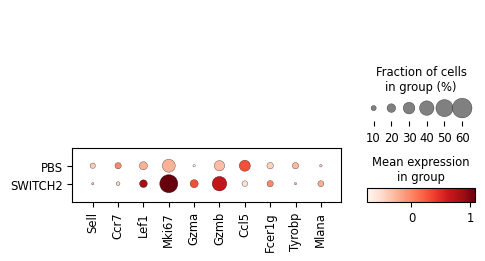

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\plotting\_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


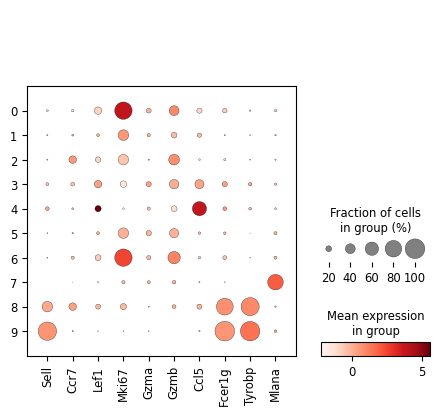

In [37]:
sc.pl.dotplot(adata, marker_genes, 'sample', dendrogram=False, save ='_sample')
sc.pl.dotplot(adata, marker_genes, 'clusters', dendrogram=False, save ='_clusters')

In [38]:
adata.layers['scaled'] = sc.pp.scale(adata, copy=True).X
#adata.layers

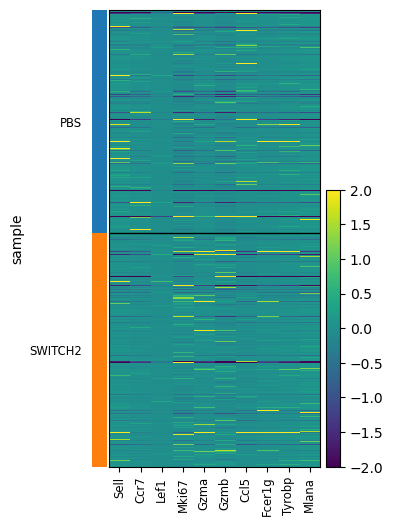

In [39]:
sc.pl.heatmap(adata, marker_genes, groupby='sample', layer='scaled', vmin=-2, vmax=2, cmap='viridis', save ='_sample') # changer les vmin et vmax pour faire ressortir les valeurs

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_gen

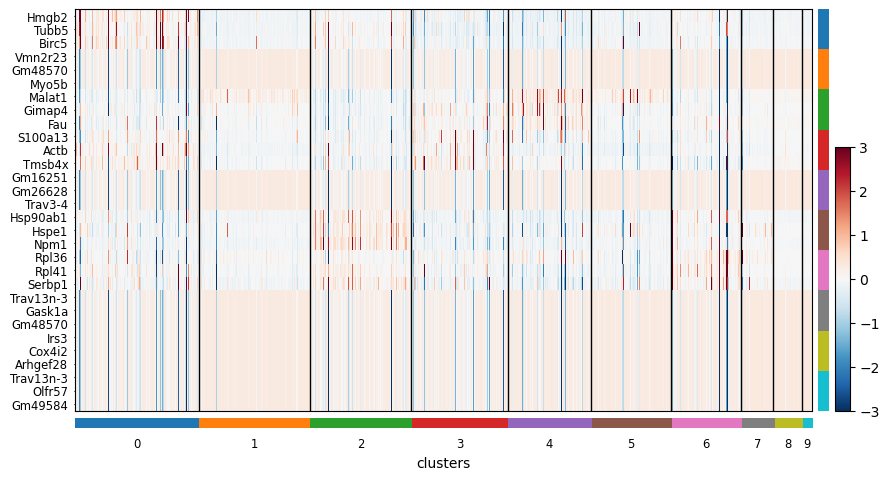

In [40]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups_heatmap(adata,groupby='clusters',cmap='RdBu_r', layer='scaled', n_genes=3,  dendrogram=False, swap_axes=True, vmin=-3, vmax=3, save ='_cluster')

- Proportion de cellule de l'échantillon 1 dans le cluster n vs échantillon de cellule de l'échantillon 2 dans le cluster n (et ce pour chaque cluster).

In [41]:
#ne sert plus à rien
'''print(adata.obs['clusters'])
#pour voir ou ce fait la séparation entre les deux échantillion comme les résultats sont groupé 
for i in range(len(adata.obs['sample'])):
    if adata.obs['sample'][i] == 'SWITCH2':
        print(i)
        break
print (adata.obs['sample'][2507], adata.obs['sample'][2508])'''

"print(adata.obs['clusters'])\n#pour voir ou ce fait la séparation entre les deux échantillion comme les résultats sont groupé \nfor i in range(len(adata.obs['sample'])):\n    if adata.obs['sample'][i] == 'SWITCH2':\n        print(i)\n        break\nprint (adata.obs['sample'][2507], adata.obs['sample'][2508])"

In [42]:
cluster_counts = adata.obs.groupby(['clusters', 'sample'])['clusters'].count().unstack() # récupérer les infos de cluster par sample
#type(cluster_counts)

In [43]:
#cluster_counts

In [44]:
#cluster_counts.values[0, :]

In [45]:
#modifier pour avoir des fréquence et non des comptages
#cluster_counts.index
cluster_counts.values

array([[309, 557],
       [494, 277],
       [401, 307],
       [357, 316],
       [482,  99],
       [ 57, 499],
       [113, 377],
       [ 42, 183],
       [187,   9],
       [ 66,   6]], dtype=int64)

In [46]:
len(cluster_counts.index)

10

In [47]:
# a la main
'''plt.bar(range(len(cluster_counts.values[0, :])), cluster_counts.values[0, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[1, :])), cluster_counts.values[1, :], bottom=cluster_counts.values[0, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[2, :])), cluster_counts.values[2, :], bottom=cluster_counts.values[1, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[3, :])), cluster_counts.values[3, :], bottom=cluster_counts.values[2, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[4, :])), cluster_counts.values[4, :], bottom=cluster_counts.values[3, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[5, :])), cluster_counts.values[5, :], bottom=cluster_counts.values[4, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[6, :])), cluster_counts.values[6, :], bottom=cluster_counts.values[5, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[7, :])), cluster_counts.values[7, :], bottom=cluster_counts.values[6, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[8, :])), cluster_counts.values[8, :], bottom=cluster_counts.values[7, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[9, :])), cluster_counts.values[9, :], bottom=cluster_counts.values[8, :], tick_label=['PBS', 'SWITCH2'])
plt.legend(labels=['0', '1','2','3','4','5','6','7','8','9'])'''

"plt.bar(range(len(cluster_counts.values[0, :])), cluster_counts.values[0, :], tick_label=['PBS', 'SWITCH2'])\nplt.bar(range(len(cluster_counts.values[1, :])), cluster_counts.values[1, :], bottom=cluster_counts.values[0, :], tick_label=['PBS', 'SWITCH2'])\nplt.bar(range(len(cluster_counts.values[2, :])), cluster_counts.values[2, :], bottom=cluster_counts.values[1, :], tick_label=['PBS', 'SWITCH2'])\nplt.bar(range(len(cluster_counts.values[3, :])), cluster_counts.values[3, :], bottom=cluster_counts.values[2, :], tick_label=['PBS', 'SWITCH2'])\nplt.bar(range(len(cluster_counts.values[4, :])), cluster_counts.values[4, :], bottom=cluster_counts.values[3, :], tick_label=['PBS', 'SWITCH2'])\nplt.bar(range(len(cluster_counts.values[5, :])), cluster_counts.values[5, :], bottom=cluster_counts.values[4, :], tick_label=['PBS', 'SWITCH2'])\nplt.bar(range(len(cluster_counts.values[6, :])), cluster_counts.values[6, :], bottom=cluster_counts.values[5, :], tick_label=['PBS', 'SWITCH2'])\nplt.bar(range

faire une ratio en frequence et non juste les comptages

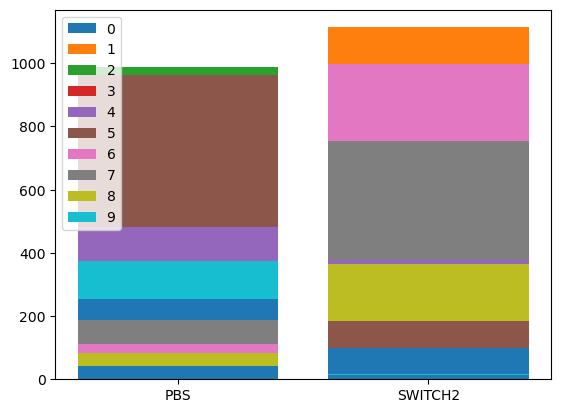

In [48]:
#un peut plus automatisé
plt.bar(range(len(cluster_counts.values[0, :])), cluster_counts.values[0, :], tick_label=['PBS', 'SWITCH2'])
plt.legend(labels=['0', '1','2','3','4','5','6','7','8','9'])
for i in range(len(cluster_counts.index)-1):
    plt.bar(range(len(cluster_counts.values[i , :])), cluster_counts.values[ i, :], bottom=cluster_counts.values[i, :], tick_label=['PBS', 'SWITCH2'])
plt.bar(range(len(cluster_counts.values[len(cluster_counts.index)-1 , :])), cluster_counts.values[len(cluster_counts.index)-1, :], bottom=cluster_counts.values[len(cluster_counts.index)-2, :], tick_label=['PBS', 'SWITCH2'])
plt.legend(labels=['0', '1','2','3','4','5','6','7','8','9'])
plt.savefig('./figures/Sample_cluster_composition.pdf')

 - Expression différentielle entre les cellules de l'échantillon 1 dans le cluster n vs les cellules de l'échantillon 2 dans le cluster n (et ce pour chaque cluster).

Vous pourrez visualisez avec une heatmap.

In [49]:
#créations des sous-unité pour faire les heatmap on aura S1C1, etc
for i in range(len(adata.obs['clusters'])):
    globals()[f'S1C{i}'] = adata[(adata.obs['sample'] == 'PBS') & (adata.obs['clusters'] == str(i)), :]
    globals()[f'S2C{i}'] = adata[(adata.obs['sample'] == 'SWITCH2') & (adata.obs['clusters'] == str(i)), :]
#S2C4.shape

C:\ProgramData\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


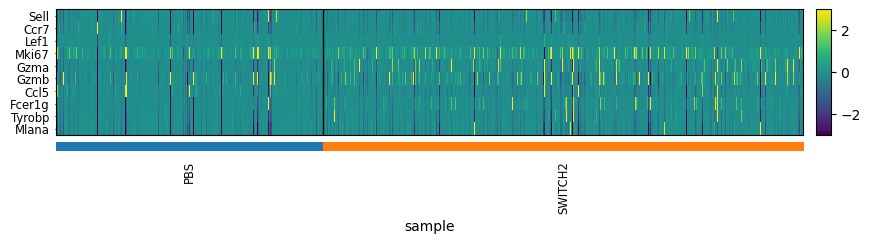

In [53]:
sc.pl.heatmap(S1C0.concatenate(S2C0), marker_genes, groupby='sample', cmap='viridis', dendrogram=False,vmin=-3, vmax=3, layer='scaled', swap_axes=True, save = '_ttttt')

C:\ProgramData\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


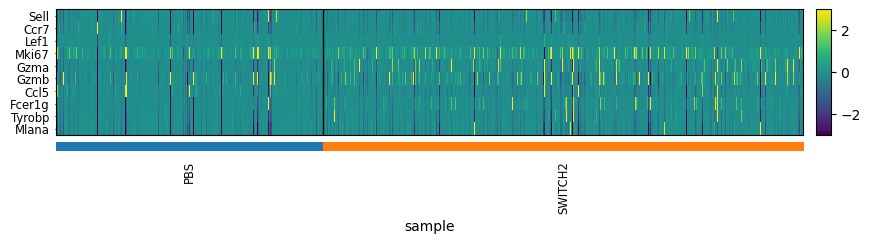

In [54]:
iii = 0
sc.pl.heatmap(globals()[f'S1C{iii}'].concatenate(globals()[f'S2C{iii}']), marker_genes, groupby='sample', cmap='viridis', dendrogram=False, vmin=-3, vmax=3, layer='scaled', swap_axes=True, save='_ttttt')


In [52]:
#il me fait de la génération infini de graph ...
'''
def plot_graph(b):
    if b == 'All':
        for i in range(len(adata.obs['clusters'])): 
            sc.pl.heatmap(globals()[f'S1C{i}'].concatenate(globals()[f'S2C{i}']), marker_genes, groupby='sample', cmap='viridis', dendrogram=False, vmin=-3, vmax=3, layer='scaled', swap_axes=True, save='_ttttt')
            #mettre des titres 
    else : 
        
        print('to do')

interact(
    plot_graph,
    b = [ 'All'],

)'''

"\ndef plot_graph(b):\n    if b == 'All':\n        for i in range(len(adata.obs['clusters'])): \n            sc.pl.heatmap(globals()[f'S1C{i}'].concatenate(globals()[f'S2C{i}']), marker_genes, groupby='clusters', cmap='viridis', dendrogram=False, vmin=-3, vmax=3, layer='scaled', swap_axes=True, save='_ttttt')\n            #mettre des titres \n    else : \n        \n        print('to do')\n\ninteract(\n    plot_graph,\n    b = [ 'All'],\n\n)"